For anyone taking a quick look, the beginning of this notebook is rough work and code kept for reference. The final analysis begins at the heading below.

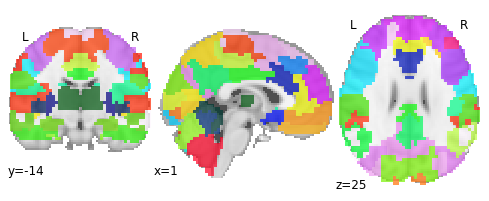

In [15]:
from nilearn import plotting
plotting.plot_roi(atlas_filename, draw_cross = False)

In [48]:
print(fmri_masked.shape)

(185, 64)


In [45]:
#THIS WORKS
#If word was presented replace null in next NaN in following row with word from previous
#May be useful for monitoring activity both before and after word
for i in events.index:
    if events.loc[i, 'trial_type'] == 'ListenWord':
        events.loc[i+1, 'Word'] = events.loc[i, 'Word']
        events.loc[i+1, 'trial_type'] = 'AfterWord'

# Predicting Schizophrenia Diagnosis

In [2]:
#import data
from nilearn import datasets
data = datasets.fetch_cobre()

In [7]:
#import phenotypic data
import pandas
pheno = pandas.DataFrame(data.phenotypic)

In [8]:
#extract participant id from file paths
file_names = []
for path in data.func:
    
    file_names.append(path[40:45])

In [9]:
#create dataframe of file paths and ids
files = pandas.DataFrame(data.func, columns = ['path'])
files['id'] = file_names
files['id'] = files.id.astype(int)

In [10]:
#merge phenotypic data with file paths
import pandas
pheno = pandas.merge(pheno, files, on = 'id')
#fix string decoding
pheno['gender'] = pheno['gender'].map(lambda x: x.decode('utf-8'))
pheno['handedness'] = pheno['handedness'].map(lambda x: x.decode('utf-8'))
pheno['subject_type'] = pheno['subject_type'].map(lambda x: x.decode('utf-8'))
pheno['diagnosis'] = pheno['diagnosis'].map(lambda x: x.decode('utf-8'))

In [11]:
pheno

,id,current_age,gender,handedness,subject_type,diagnosis,frames_ok,fd,fd_scrubbed,path
0,40061,18,Male,Right,Control,None,133,0.25512,0.22657,/home/aalbury/nilearn_data/cobre/fmri_0040061....
1,40090,18,Female,Right,Control,None,150,0.16963,0.16963,/home/aalbury/nilearn_data/cobre/fmri_0040090....
2,40046,18,Male,Left,Patient,295.70 depressed type,76,0.37504,0.30042,/home/aalbury/nilearn_data/cobre/fmri_0040046....
3,40002,19,Male,Right,Patient,295.3,67,0.40006,0.21575,/home/aalbury/nilearn_data/cobre/fmri_0040002....
4,40117,19,Male,Right,Patient,295.3,133,0.20975,0.18410,/home/aalbury/nilearn_data/cobre/fmri_0040117....
5,40145,19,Male,Right,Patient,295.6,144,0.16429,0.15521,/home/aalbury/nilearn_data/cobre/fmri_0040145....
6,40113,20,Male,Right,Control,None,126,0.19962,0.15790,/home/aalbury/nilearn_data/cobre/fmri_0040113....
7,40000,20,Female,Right,Patient,295.9,140,0.21234,0.20245,/home/aalbury/nilearn_data/cobre/fmri_0040000....
8,40121,21,Female,Right,Control,None,145,0.25869,0.25791,/home/aalbury/nilearn_data/cobre/fmri_0040121....
9,40020,22,Male,Right,Control,None,135,0.20898,0.19203,/home/aalbury/nilearn_data/cobre/fmri_0040020....


In [12]:
#create lists of filepaths for patients and controls
patients = []
controls = []

for i in pheno.index:
    if pheno.loc[i, 'subject_type']=='Patient':
    
        patients.append(pheno.loc[i, 'path'])
    else:
        controls.append(pheno.loc[i, 'path'])


In [13]:
patients

['/home/aalbury/nilearn_data/cobre/fmri_0040046.nii.gz',
 '/home/aalbury/nilearn_data/cobre/fmri_0040002.nii.gz',
 '/home/aalbury/nilearn_data/cobre/fmri_0040117.nii.gz',
 '/home/aalbury/nilearn_data/cobre/fmri_0040145.nii.gz',
 '/home/aalbury/nilearn_data/cobre/fmri_0040000.nii.gz']


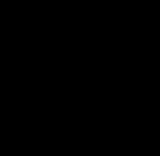
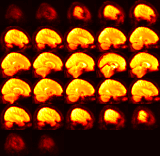

In [14]:
from nilearn import plotting
from nilearn.image import mean_img, smooth_img

plotting.view_img(mean_img(patients), threshold=None, bg_img=False)



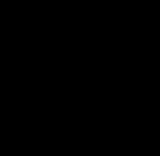
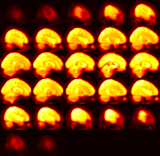

In [15]:
plotting.view_img(smooth_img(mean_img(controls), fwhm = 'fast'), threshold=None, bg_img=False)


In [16]:
import plotly.express as px
from jupyter_dash import JupyterDash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
# Load Data
df = pheno
# Build App
app = JupyterDash(__name__)
app.layout = html.Div([
    html.H1("Age"),
    dcc.Graph(id='graph'),
    html.Label([
        "Participant type",
        dcc.Dropdown(
            id='subject_type', clearable=False,
            value='Patient', options=[
                {'label': c, 'value': c}
                for c in df.subject_type.unique()
            ])
    ]),
])
# Define callback to update graph
@app.callback(
    Output('graph', 'figure'),
    [Input("subject_type", "value")]
)
def update_figure(subject_type):
    return px.histogram(
        df[df["subject_type"]==subject_type], x="current_age",
        
        #render_mode="webgl", title="Diagnosis"
    )
# Run app and display result inline in the notebook
app.run_server(mode='inline')

In [ ]:
#import atlas
parcellations = datasets.fetch_atlas_basc_multiscale_2015(version='sym')
atlas_filename = parcellations.scale064

In [20]:
# create mask
from nilearn.input_data import NiftiLabelsMasker
from nilearn.connectome import ConnectivityMeasure

mask = NiftiLabelsMasker(labels_img=atlas_filename, 
                           standardize=True, 
                           memory='nilearn_cache', 
                           verbose=1)

# initialize correlation measure
correlation_measure = ConnectivityMeasure(kind='correlation', vectorize=True,
                                         discard_diagonal=True)

In [33]:
import pandas as pd
all_features = pd.DataFrame(columns=['features', 'file'])

for i,sub in enumerate(data.func):
    # extract the timeseries from the ROIs in the atlas
    time_series = mask.fit_transform(sub, confounds=data.confounds[i])
    # create a region x region correlation matrix
    correlation_matrix = correlation_measure.fit_transform([time_series])[0]
    # add to our container
    all_features = all_features.append({'features': correlation_matrix, 'file': data.func[i]}, ignore_index=True)
    # keep track of status
    print('finished %s of %s'%(i+1,len(data.func)))

[NiftiLabelsMasker.fit_transform] loading data from /home/aalbury/nilearn_data/basc_multiscale_2015/template_cambridge_basc_multiscale_nii_sym/template_cambridge_basc_multiscale_sym_scale064.nii.gz
finished 1 of 10
[NiftiLabelsMasker.fit_transform] loading data from /home/aalbury/nilearn_data/basc_multiscale_2015/template_cambridge_basc_multiscale_nii_sym/template_cambridge_basc_multiscale_sym_scale064.nii.gz
finished 2 of 10
[NiftiLabelsMasker.fit_transform] loading data from /home/aalbury/nilearn_data/basc_multiscale_2015/template_cambridge_basc_multiscale_nii_sym/template_cambridge_basc_multiscale_sym_scale064.nii.gz
finished 3 of 10
[NiftiLabelsMasker.fit_transform] loading data from /home/aalbury/nilearn_data/basc_multiscale_2015/template_cambridge_basc_multiscale_nii_sym/template_cambridge_basc_multiscale_sym_scale064.nii.gz
finished 4 of 10
[NiftiLabelsMasker.fit_transform] loading data from /home/aalbury/nilearn_data/basc_multiscale_2015/template_cambridge_basc_multiscale_nii_s

In [35]:
# create pandas dataframe of features and phenotypic data
full = pandas.merge(pheno, all_features, left_on = 'path', right_on = 'file')

In [37]:
full

,id,current_age,gender,handedness,subject_type,diagnosis,frames_ok,fd,fd_scrubbed,path,features,file
0,40061,18,Male,Right,Control,None,133,0.25512,0.22657,/home/aalbury/nilearn_data/cobre/fmri_0040061....,"[0.12785325357282862, 0.24422311479417322, 0.0...",/home/aalbury/nilearn_data/cobre/fmri_0040061....
1,40090,18,Female,Right,Control,None,150,0.16963,0.16963,/home/aalbury/nilearn_data/cobre/fmri_0040090....,"[0.05584897620355883, 0.11246991477285287, 0.0...",/home/aalbury/nilearn_data/cobre/fmri_0040090....
2,40046,18,Male,Left,Patient,295.70 depressed type,76,0.37504,0.30042,/home/aalbury/nilearn_data/cobre/fmri_0040046....,"[0.08678037911430761, 0.06380639929297223, 0.2...",/home/aalbury/nilearn_data/cobre/fmri_0040046....
3,40002,19,Male,Right,Patient,295.3,67,0.40006,0.21575,/home/aalbury/nilearn_data/cobre/fmri_0040002....,"[0.1456258349041035, -0.06313977045762048, 0.0...",/home/aalbury/nilearn_data/cobre/fmri_0040002....
4,40117,19,Male,Right,Patient,295.3,133,0.20975,0.18410,/home/aalbury/nilearn_data/cobre/fmri_0040117....,"[0.17462308889197792, -0.11825290188441862, -0...",/home/aalbury/nilearn_data/cobre/fmri_0040117....
5,40145,19,Male,Right,Patient,295.6,144,0.16429,0.15521,/home/aalbury/nilearn_data/cobre/fmri_0040145....,"[-0.030583214196113272, -0.03463510411559695, ...",/home/aalbury/nilearn_data/cobre/fmri_0040145....
6,40113,20,Male,Right,Control,None,126,0.19962,0.15790,/home/aalbury/nilearn_data/cobre/fmri_0040113....,"[-0.01669774730802078, -0.1471218208894485, 0....",/home/aalbury/nilearn_data/cobre/fmri_0040113....
7,40000,20,Female,Right,Patient,295.9,140,0.21234,0.20245,/home/aalbury/nilearn_data/cobre/fmri_0040000....,"[-0.005440252066358948, -0.0004542389778303733...",/home/aalbury/nilearn_data/cobre/fmri_0040000....
8,40121,21,Female,Right,Control,None,145,0.25869,0.25791,/home/aalbury/nilearn_data/cobre/fmri_0040121....,"[0.2021039892772866, 0.05848323378809054, 0.34...",/home/aalbury/nilearn_data/cobre/fmri_0040121....
9,40020,22,Male,Right,Control,None,135,0.20898,0.19203,/home/aalbury/nilearn_data/cobre/fmri_0040020....,"[0.20209790439695283, -0.07562380234638054, -0...",/home/aalbury/nilearn_data/cobre/fmri_0040020....


## Classification

In [56]:
from sklearn.model_selection import train_test_split

# Split the sample to training/validation with a 60/40 ratio, and 
# stratify by age class, and also shuffle the data.

x_train, x_val, y_train, y_val = train_test_split(
                                                    list(full['features']), # x
                                                    full['subject_type'], # y
                                                    test_size = 0.4, # 60%/40% split  
                                                    shuffle = True, # shuffle dataset
                                                                    # before splitting
                                                    random_state = 242 
                                                                       )

In [57]:
# import classifier
from sklearn.svm import SVC
svc = SVC(kernel='linear')

In [58]:
#train model
svc.fit(x_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [62]:
prediction = svc.predict(x_train)

# caluclate the model accuracy
acc = svc.score(x_train, y_train)
print(acc)

1.0


1.0
